Wavefront Sensing 

In [1]:
import pandas as pd
import sympy as sp
import numpy as np
import math
import scipy as spy
import scipy.special as special
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit

from sympy import Symbol 
from sympy import symbols 
from sympy import *
from sympy import Integral, oo, exp, pi, integrate
from sympy import oo
from sympy import sinc
infinity=oo
k,a,y,f,phi = symbols("k,a,y,f,phi")
init_printing(use_unicode=False, wrap_line=False)

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Part 1 - Obtaining the power via integrating the intensity on the detectors, found from Fourier-Transforming a top-hat function input electric field through a single slit aperture in y. The intensity is the following integrand, in units of Watts/Meter due to being in 1D (y)

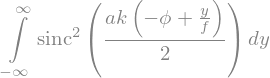

In [2]:
#Setting up power integral
integrate((sinc(k*a/2*(y/f-phi)))**2,(y,-infinity,infinity))

Import .txt file for wavefront data

[1. 1. 0. ... 0. 0. 0.]
6.0 p2min
2690 end
18.53286311371721 v


<ipython-input-3-304dbfbc6c01>:57: RuntimeWarning: divide by zero encountered in true_divide
  signal_data = (p1data-p2data)/(p1data+p2data)
<ipython-input-3-304dbfbc6c01>:57: RuntimeWarning: invalid value encountered in true_divide
  signal_data = (p1data-p2data)/(p1data+p2data)


<Figure size 432x288 with 0 Axes>

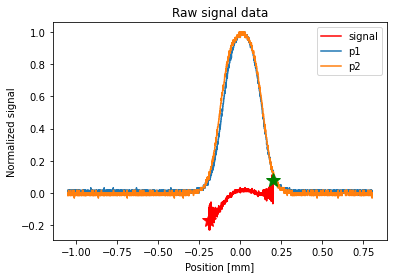

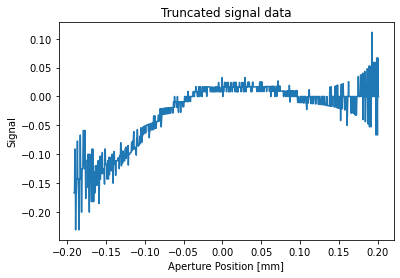

<Figure size 432x288 with 0 Axes>

In [3]:
#Import .txt file from .xls wavefront data

#Data for laser waist starting at z = 0 cm
p1data = np.loadtxt("Detector1.txt", skiprows=32,max_rows=8000)
p2data = np.loadtxt("Detector2.txt", skiprows=32,max_rows=8000)
print(p1data[:])

#p1 + p2 = column 3, index =[:,2]
#p1 - p2 = column 4, index = [:,3]
#filter = column 5, index = [:,4]
#signal = column 6, index = [:,5]
#Integrated signal = column 7, index = [:,6]

print(abs(min(p2data)-min(p1data)), 'p2min')

p2data = p2data - abs(min(p1data)-min(p2data)) - 1
p1data = p1data

#Determining end and start markers for data cutoff point
count = 0
def find_start(arr):
    global count
    for i in range(len(arr)):
        if arr[i] <= 0.1*arr.max():
            continue
        else:
            count = i
            break
    return count
            
def find_end(arr):
    for j in range(len(arr)):
        if arr[j+arr.argmax()] >= 0.1*arr.max():
            continue
        else:
            end = j+arr.argmax()
            print(end,'end')
            break
    return end

start = find_start(p2data)
end = find_end(p2data)


r = 73.15e-3 #radial distance from center aperture to center pinhole (meters)
period = 24.8e-3 #time for of pinhole to complete one cycle in angular displacement (seconds)
omega = 2*np.pi/period #angular velocity of pinhole
v = r*omega #linear velocity along aperture plane (y) (m/s)
print(v,'v')
y0 = -1.05e-3 #estimated starting position of pinhole at aperture plane (below y = 0)
T = len(p1data) #Times for length of data
time = np.linspace(0,100e-6,T) #Normalized time with T data points (seconds)
yprime = (y0+v*time)
scale = 1e3 #meters to millimeter scaling factor
yscaled = scale*yprime #phi = y/R, where y along aperture plane is expressed as a function of time

signal_data = (p1data-p2data)/(p1data+p2data)

#Observe signal with a plot to find meaningful data
plt.plot(yscaled[start:end],signal_data[start:end],'r-')
plt.plot(yscaled,p1data/max(p1data))
plt.plot(yscaled,p2data/max(p2data))
plt.legend(['signal','p1','p2'])
        
#Plot truncated signal
plt.plot(yscaled[start],signal_data[start], '*r', ms = 15)
plt.plot(yscaled[end],signal_data[end], '*g', ms = 15)
plt.ylabel('Normalized signal')
plt.xlabel('Position [mm]')
plt.title('Raw signal data')
plt.figure()

#Plot of truncated signal extracted from raw data
plt.plot(yscaled[start:end],signal_data[start:end])
plt.ylabel('Signal')
plt.xlabel('Aperture Position [mm]')
plt.title('Truncated signal data')
plt.figure()

In [4]:
k=2*np.pi/(632.8e-9) #(in inverse meters)
a=1e-5 #(in meters) diameter of pinhole
f=0.125 #(in meters)
phi=0.000632 #(i..e. 1λ deviation over a 1mm wide beam)

#power on detector 2 (lower)

def sinc_int(y, a, k, f, phi):
    return  special.sinc(k*(a/2)*(y/f-phi))**2

p2 = quad(sinc_int, -infinity,0, args=(a,k,f,phi))
p2

#p2 = Integral((special.sinc(k*a*(y/f-phi)))**2,(y,-oo,0))
#f = lambdify(phi, p2, modules={"Integral": integral_as_quad})
#p2 = sp.lambdify([phi,y],p2,"numpy")
#f(.01)

<ipython-input-4-2bb292db8a43>:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p2 = quad(sinc_int, -infinity,0, args=(a,k,f,phi))


In [5]:
#power on detector 1 (upper)
p1 = quad(sinc_int,0,infinity, args=(a,k,f,phi))
#p1 = p1.evalf(sub)
p1

<ipython-input-5-d129b54a5a6c>:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p1 = quad(sinc_int,0,infinity, args=(a,k,f,phi))


In [6]:
#S = p(detector1)-p(detector2)
signal = p1[0] - p2[0]
print('Power on detector 1 is: ', p1,'W')
print('Power on detector 2 is: ', p2,'W')
print('The total signal is: ', signal,'W')

Power on detector 1 is:  (0.001337650132621638, 4.046709009368982e-06) W
Power on detector 2 is:  (0.0011798860816455735, 3.952302698561786e-06) W
The total signal is:  0.00015776405097606442 W


Generate an N array of signal values given N-angles $\phi$

In [7]:
#N matches number of truncated data points acquired from experiment
N = end-start
print(N)

ylim = 1e-2
angle = np.linspace(-.02,.02,N).reshape(N)
power_plt = np.zeros(N)

for i in range(N):
    phi = angle[i] #current tilt angle being fed into power integrals
    sig1 = quad(sinc_int, 0, ylim, args=(a,k,f,phi)) #power detector 1
    sig2 = quad(sinc_int, -ylim, 0, args=(a,k,f,phi)) #power detector 2
    power_plt[i] = (sig1[0] - sig2[0])/(sig1[0]+sig2[0]) #normalized signal



    
print(power_plt)

844
[-0.9209201  -0.92092002 -0.92091975 -0.92091924 -0.92091843 -0.92091726
 -0.92091568 -0.92091362 -0.92091104 -0.92090787 -0.92090404 -0.92089951
 -0.92089421 -0.92088807 -0.92088103 -0.92087304 -0.92086402 -0.92085391
 -0.92084264 -0.92083015 -0.92081637 -0.92080123 -0.92078466 -0.92076659
 -0.92074696 -0.92072569 -0.92070271 -0.92067794 -0.92065132 -0.92062278
 -0.92059222 -0.92055959 -0.92052481 -0.92048779 -0.92044846 -0.92040675
 -0.92036257 -0.92031585 -0.9202665  -0.92021445 -0.92015962 -0.92010191
 -0.92004126 -0.91997757 -0.91991077 -0.91984077 -0.91976748 -0.91969082
 -0.9196107  -0.91952704 -0.91943975 -0.91934874 -0.91925392 -0.91915521
 -0.91905251 -0.91894573 -0.91883479 -0.91871959 -0.91860004 -0.91847605
 -0.91834752 -0.91821437 -0.9180765  -0.91793381 -0.91778621 -0.9176336
 -0.9174759  -0.917313   -0.9171448  -0.91697121 -0.91679213 -0.91660747
 -0.91641712 -0.91622099 -0.91601898 -0.91581098 -0.91559691 -0.91537665
 -0.9151501  -0.91491718 -0.91467776 -0.91443176

Enter total signal power measured on both detectors between 
 -0.9209200979044784 and 0.9209200979044784 .5
(0.4997090844195961, 0.503518299029977, 533, 534)
The closest value to 0.5 is [0.4997090844195961, 0.503518299029977]
The phase gradient is at 0.0052942525047940565 rad.


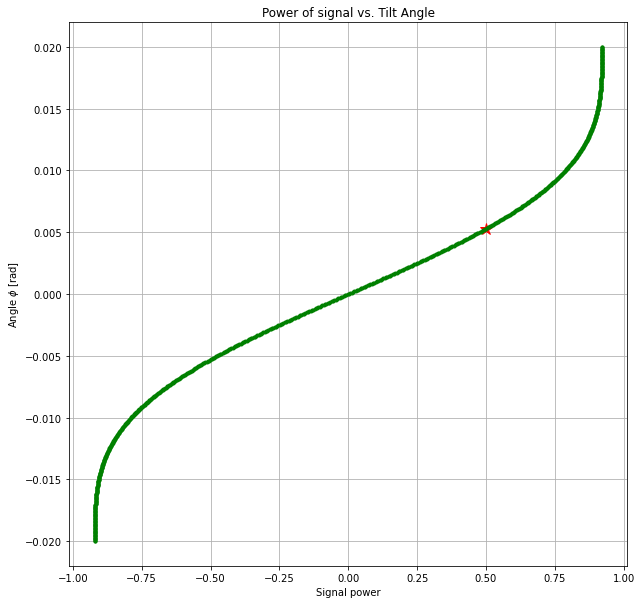

[0.4997090844195961, 0.503518299029977] [0.005290628706998812, 0.005338078291814947]
533 534


In [8]:
#Interpolation scheme to pick out phase gradient, phi
def closest_values(input_array, input_value):
        arr = input_array #Takes in power values s = p1-p2
        k = (np.abs(arr - input_value)).argmin() #Index of smallest difference, to left.
        if input_value < arr[k]:
            k = k-1
        j = k+1
        return arr[k],arr[j],k,j #returns 4-element tuple 
        
#Enter your measured power on the detectors

p_new = eval(input('Enter total signal power measured on both detectors between \n '
                    + str(power_plt[0]) + ' and ' + str(power_plt[-1]) + ' '))
                                                                                                                               
print(closest_values(power_plt,p_new))
p=list(closest_values(power_plt,p_new))[0:2] #Picks out first two values of Tuple 
print("The closest value to "+ str(p_new)+" is",p)

#p = list(closest_values(power_plt,p_new))[0:2] #Turns first two tuple elements into list
k,j = list(closest_values(power_plt,p_new))[2:] #Turns last two tuple elements into list (indices)
#p = [power_plt[k],power_plt[j]]
ang = [angle[k], angle[j]] #phi at same indices as power


a_new = np.interp(p_new, p, ang) #Use numpy interp function to create estimated phi
print('The phase gradient is at',a_new,'rad.')
#End of interpolation scheme

#Plot phi(power) 
plt.figure(figsize=(10,10))
plt.plot(p, ang, "g-", p_new, a_new, '*r',markersize=12) #plots interpolation line and point
plt.plot(power_plt,angle,'g.') #plots data of N points
plt.grid(True)
plt.title('Power of signal vs. Tilt Angle')
plt.ylabel(r'Angle $\phi$ [rad]')
plt.xlabel('Signal power')
plt.show()
print(p, ang)
print(k,j)

Part 2 - We just retrieved the phase gradient $\phi (p)$ of a single piece of the gaussian wavefront diffracting through a single slit aperture. We need to infer the phase gradient of every piece from our new signal power function.

[-0.9209201  -0.92092002 -0.92091975 -0.92091924 -0.92091843 -0.92091726
 -0.92091568 -0.92091362 -0.92091104 -0.92090787 -0.92090404 -0.92089951
 -0.92089421 -0.92088807 -0.92088103 -0.92087304 -0.92086402 -0.92085391
 -0.92084264 -0.92083015 -0.92081637 -0.92080123 -0.92078466 -0.92076659
 -0.92074696 -0.92072569 -0.92070271 -0.92067794 -0.92065132 -0.92062278
 -0.92059222 -0.92055959 -0.92052481 -0.92048779 -0.92044846 -0.92040675
 -0.92036257 -0.92031585 -0.9202665  -0.92021445 -0.92015962 -0.92010191
 -0.92004126 -0.91997757 -0.91991077 -0.91984077 -0.91976748 -0.91969082
 -0.9196107  -0.91952704 -0.91943975 -0.91934874 -0.91925392 -0.91915521
 -0.91905251 -0.91894573 -0.91883479 -0.91871959 -0.91860004 -0.91847605
 -0.91834752 -0.91821437 -0.9180765  -0.91793381 -0.91778621 -0.9176336
 -0.9174759  -0.917313   -0.9171448  -0.91697121 -0.91679213 -0.91660747
 -0.91641712 -0.91622099 -0.91601898 -0.91581098 -0.91559691 -0.91537665
 -0.9151501  -0.91491718 -0.91467776 -0.91443176 -0.

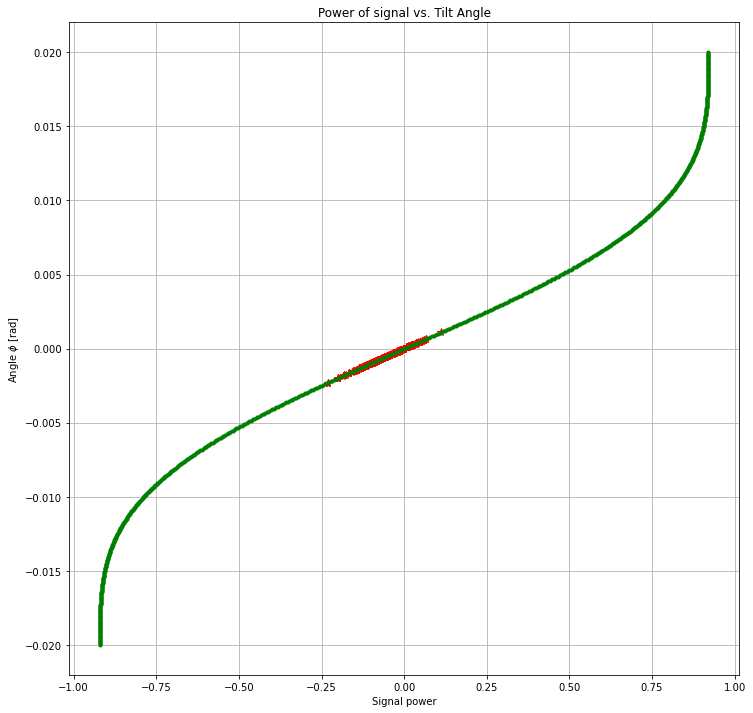

Text(0.5, 0, 'Data points')

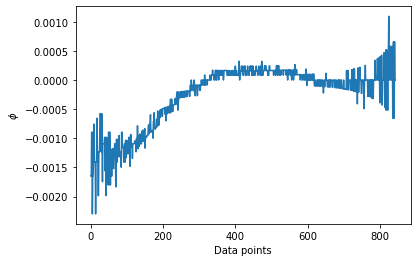

In [9]:
#Interpolating between every data point
    
print(power_plt)
a_new = np.zeros(N)
p_new = np.zeros(N)

for i in range(N):
   
    #p_new is the interpolated signal to produce an angle, phi
    #data[:,5] is the truncated data for signal acquired in column 6 in the .txt/.xls file
    
    p_new[i] = signal_data[i+start]
                                                                                                                   
    #Find closest two power data points to interpolate between

    print(closest_values(power_plt,p_new[i]))
    if p_new[i] == 0:
        a_new[i] = 0
        continue
    p=list(closest_values(power_plt,p_new[i]))[0:2] #Picks out first two values of Tuple 
    print("The closest values to "+ str(p_new[i])+" is",p)

    #p = list(closest_values(power_plt,p_new))[0:2] #Turns first two tuple elements into list
    k,j = list(closest_values(power_plt,p_new[i]))[2:] #Turns last two tuple elements into list (indices)
    #p = [power_plt[k],power_plt[j]]
    ang = [angle[k], angle[j]] #phi at same indices as power

    
    a_new[i] = np.interp(p_new[i], p, ang) #Use numpy interp function to create estimated phi

    
    
print(a_new)
#Plot phi(power)

#Plot phi(power) 
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(12,12))
plt.plot(p, ang, "g-", p_new, a_new, '*r',markersize=8) #plots interpolation line and point
plt.plot(power_plt,angle,'g.') #plots data of N points
plt.grid(True)
plt.title('Power of signal vs. Tilt Angle')
plt.ylabel(r'Angle $\phi$ [rad]')
plt.xlabel('Signal power')
plt.show()
plt.figure()
plt.plot(a_new)
plt.ylabel(r'$\phi$')
plt.xlabel('Data points')


Obtain width of the beam, w(z=0)

In [10]:
#Acquire total power, p1+p2
totalpower = np.array(p1data + p2data)
#Filter totalpower data by removing any values below zero
for i in range(len(totalpower)):
    if totalpower[i] <= 0:
        totalpower[i] = 0

#The following function finds the FWHM of the data for P1+P2
def FWHM(input_array):
        arr = input_array #Takes in power values s = p1-p2
        center = list(arr).index(max(arr)) #Obtain index for center of Gaussian from Data
        k = abs((max(arr)/2 - arr[0:center])).argmin() #Index first half maximum
        j = int(center) + abs((arr[center:-1] - max(arr)/2)).argmin() #Index second half maximum
        return time[j] - time[k] #FWHM

r = 73.15e-3 #meters
period = 24.8e-3 #seconds
omega = 2*np.pi/period
T = len(totalpower) #Times for length of data
t = np.linspace(0,100e-6,T) #Normalized time with T data points (seconds)
v = r*omega #velocity of the moving aperture m/s
#y0 = -4.25e-4 #meters 
Lambda = 632.8e-9 #meters
delta_y = v*40e-6
print(delta_y)
    

n = 1 #Index of refraction
#E_0 = np.sqrt(max(totalpower)) #V/m, picks out amplitude of gaussian from data


#Theoretical power curve using the FWHM of the data
def Power(t,E_0,y0,w):
    p = E_0**2 * np.e**(-2*((y0+v*t)/(w))**2)
    return p

from scipy.optimize import curve_fit 

parameters, covariance = curve_fit(Power, t, totalpower) 
  
E_0 = parameters[0] 
y0 = parameters[1] 
w_ap = parameters[2]

#Use fit parameters from curve-fit to substitute into power function
fit_y = Power(t,E_0, y0, w_ap)


#Changes the amplitude to match data amplitude
Gauss_fit = fit_y*(1-abs(max(totalpower)-max(Power(t,E_0, y0, w_ap)))/max(Power(t,E_0, y0, w_ap)))
print(y0,'y0')

0.0007413145245486884
-0.001059755037599342 y0


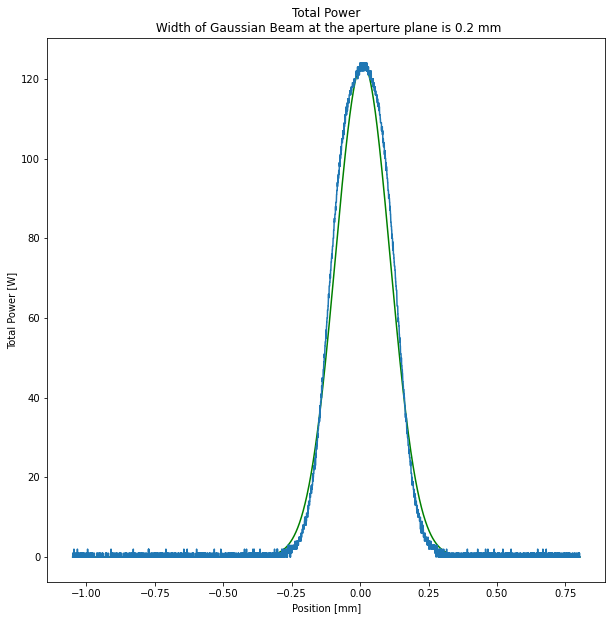

In [11]:
#Plot phi(power) 
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,10))
plt.plot(yscaled, Gauss_fit, "g-") #plots interpolation line and point
plt.plot(yscaled,totalpower)
plt.title('Total Power' +
          '\n Width of Gaussian Beam at the aperture plane is ' + str(1e3*round(w_ap,7)) + ' mm')
plt.ylabel(r'Total Power [W]')
plt.xlabel('Position [mm]')
plt.show()

1. Create curve-fit functions and apply to $\phi (t)$ data to obtain R
2. Create a plot of $\Delta z$ vs. t with obtained radius of curvature, R
3. Apply curve-fit with noise to data, and perform linear regression. Since 
$\phi = \frac{d\Delta z}{dt}$, the quadratic $\Delta z$ has a derivative that is linear.

In [12]:
#Curve-fitting functions for both linear regression and polynomials
from pylab import *
import matplotlib.pyplot as plt
import numpy as np



def dinput(input_text) :
    return int(input(input_text))

def finput(input_text) :
    return float(input(input_text))

def ainput(input_prompt) :
    '''
    Function to convert user input of a list or tuple of values to a numpy array.
    Input format can be like "1,2" or "[1,2]" or "(1,2)" etc
    '''
    return(array(eval(input(input_prompt))))

def linreg(x,y,sigma):
    """Function to perform linear regression (fit a line)
       Inputs
        x       Independent variable
        y       Dependent variable
        sigma   Estimated error in y
       Outputs
        a_fit   Fit parameters; a(1) is intercept, a(2) is slope
        sig_a   Estimated error in the parameters a()
        yy      Curve fit to the data
        chisqr  Chi squared statistic
    """
    
    #* Evaluate various sigma sums
    s = 0.; sx = 0.; sy = 0.; sxy = 0.; sxx = 0.
    for i in range(len(x)):
        sigmaTerm = sigma[i]**(-2)
        s += sigmaTerm              
        sx += x[i] * sigmaTerm
        sy += y[i] * sigmaTerm
        sxy += x[i] * y[i] * sigmaTerm
        sxx += x[i]**2 * sigmaTerm
    denom = s*sxx - sx**2

    #* Compute intercept a_fit(1) and slope a_fit(2)
    a_fit = np.empty(2)
    a_fit[0] = (sxx*sy - sx*sxy)/denom
    a_fit[1] = (s*sxy - sx*sy)/denom

    #* Compute error bars for intercept and slope
    sig_a = np.empty(2)
    sig_a[0] = np.sqrt(sxx/denom)
    sig_a[1] = np.sqrt(s/denom)

    #* Evaluate curve fit at each data point and compute Chi^2
    yy = np.empty(len(x))
    chisqr = 0.
    for i in range(len(x)):
        yy[i] = a_fit[0]*x[i]          # Curve fit to the data
        chisqr += ((y[i]-yy[i])/sigma[i] )**2    # Chi square
    return [a_fit, sig_a, yy, chisqr]

def pollsf(x, y, sigma, M):
    """Function to fit a polynomial to data
       Inputs 
        x       Independent variable
        y       Dependent variable
        sigma   Estimate error in y
        M       Number of parameters used to fit data
       Outputs
        a_fit   Fit parameters; a(1) is intercept, a(2) is slope
        sig_a   Estimated error in the parameters a()
        yy      Curve fit to the data
        chisqr  Chi squared statistic
    """

    #* Form the vector b and design matrix A   
    N = len(x)
    b = empty(N)
    A = empty((N,M))
    #print(A)
    for i in range(N):
        b[i] = y[i]/sigma[i]
        for j in range(1,M):
            A[i,j] = x[i]**(j) / sigma[i]

    #* Compute the correlation matrix C 
    C = inv( transpose(A) @ A )

    #* Compute the least squares polynomial coefficients a_fit
    a_fit = C @ ( transpose(A) @ transpose(b) ) 

    #* Compute the estimated error bars for the coefficients
    sig_a = empty(M)
    for j in range(1,M):
        sig_a[j] = sqrt(C[j,j])

    #* Evaluate curve fit at each data point and compute Chi^2
    yy = zeros(N)
    chisqr = 0
    for i in range(N):
        for j in range(1,M):
    
            yy[i] += a_fit[j]*x[i]**(j)  # yy is the curve fit
      
        chisqr += ((y[i]-yy[i]) / sigma[i])**2
        
        
    return [a_fit, sig_a, yy, chisqr]

[0.00000000e+00 2.37206630e-07 4.74413260e-07 7.11619890e-07
 9.48826520e-07 1.18603315e-06 1.42323978e-06 1.66044641e-06
 1.89765304e-06 2.13485967e-06 2.37206630e-06 2.60927293e-06
 2.84647956e-06 3.08368619e-06 3.32089282e-06 3.55809945e-06
 3.79530608e-06 4.03251271e-06 4.26971934e-06 4.50692597e-06
 4.74413260e-06 4.98133923e-06 5.21854586e-06 5.45575249e-06
 5.69295912e-06 5.93016575e-06 6.16737238e-06 6.40457901e-06
 6.64178564e-06 6.87899227e-06 7.11619890e-06 7.35340553e-06
 7.59061216e-06 7.82781879e-06 8.06502542e-06 8.30223205e-06
 8.53943868e-06 8.77664531e-06 9.01385194e-06 9.25105857e-06
 9.48826520e-06 9.72547183e-06 9.96267846e-06 1.01998851e-05
 1.04370917e-05 1.06742983e-05 1.09115050e-05 1.11487116e-05
 1.13859182e-05 1.16231249e-05 1.18603315e-05 1.20975381e-05
 1.23347448e-05 1.25719514e-05 1.28091580e-05 1.30463646e-05
 1.32835713e-05 1.35207779e-05 1.37579845e-05 1.39951912e-05
 1.42323978e-05 1.44696044e-05 1.47068111e-05 1.49440177e-05
 1.51812243e-05 1.541843

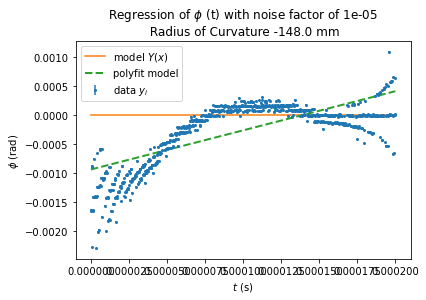

In [13]:
#We feed a_new, our acquired phi(t) angle array, into a polynomial least squares fit
#to acquire the Radius of Curvature

x = np.linspace(0,w_ap,len(a_new))
print(x)
y = a_new
dy = 1e-5*np.ones(len(a_new))
seed(0)           # Initialize random number generator
y += normal(0,dy) # add simulated measurement errors (Gaussian distributed random vector)

#* Fit the data to a straight line or a more general polynomial
M = 2
if M == 2 :  
    #* straight line fit
    [a_fit, sig_a, yy, chisqr] = linreg(x, y, dy)
else: 
    #* Polynomial fit
    [a_fit, sig_a, yy, chisqr] = pollsf(x, y, dy, M)

#* Print out the fit parameters, including their error bars.
print('Fit parameters:')
for i in range(M):
    print('a[%d] = %.15f +/- %.5f' % (i,a_fit[i],sig_a[i]))

# Use built-in numpy function:
deg = M - 1
params, cov = polyfit(x,y,deg,w=1/dy,cov=True)
dparams = sqrt( diag( cov ))
print('polyval best-fit parameters: ', params)
# variance in parameters from diagonal of covariance matrix:
print('parameter uncertainties: ', dparams)
print('Chi-square:', chisqr)


#Define our phi(t) parabola for given Radius of Curvature above
#Compare this with our calculated phi values above (in array a_new)
R = -1/a_fit[1]

# construct best-fitting model
xmod = linspace(min(x),max(x),100)
ymod = polyval(params,xmod)
#rcParams.update({'font.size': 20})
#* Graph the data, with error bars, and fitting function.
plt.figure()
plt.errorbar(x,y,dy,fmt='o',ms=2,label='data $y_i$')   # Graph data with error bars
plt.plot(x,yy,'-',label='model $Y(x)$')            # Plot the fit on same graph as data
plt.plot(xmod,ymod,'--',lw=2,label='polyfit model') # polyfit result
plt.title(r'Regression of $\phi$ (t) with noise factor of ' + str(dy[0]) + 
          '\n Radius of Curvature ' + str(1e3*round(R,3)) + ' mm')
#plt.title('Projectile Motion: ') + air_text)
xlabel('$t$ (s)')  
ylabel(r'$\phi$ (rad)')
legend(loc='best')
#speeds = r'$v_0$ = {0:.1f} '.format(speed)



#tick_params('both', length=8, width=1.2, which='major') # bigger axis ticks
plt.show()


Reconstructing the wavefront

Text(0, 0.5, 'Percent of a wavelength (633 nm)')

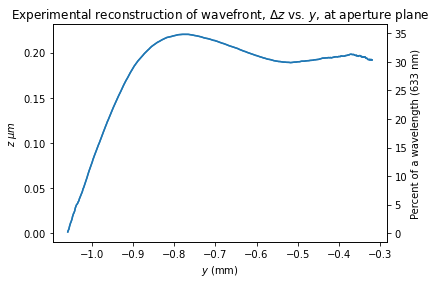

In [14]:
wavefront = []
delta_t = 40e-6/len(a_new)
delta_y = v*delta_t

z = 0
for i in range(len(a_new)):
    z += -a_new[i]*delta_y
    wavefront.append(1e6*z)

y = y0 + v*np.linspace(0,40e-6,len(a_new)) #milliseconds
y = 1e3*y #meters to millimeters

fig, ax1 = plt.subplots()

y2 = np.array(wavefront)/(1e6*Lambda)*100 #percent of a full wavelength (0.630 micrometers)

ax2 = ax1.twinx()

#plt.figure()
ax1.plot(y,wavefront,'-')            # Plot the fit on same graph as data
ax2.plot(y,y2)
ax1.set_title(r'Experimental reconstruction of wavefront, $\Delta z$ vs. $y$, at aperture plane')
#plt.title('Projectile Motion: ') + air_text)
ax1.set_xlabel('$y$ (mm)')  
ax1.set_ylabel(r'$z$ $\mu m$')
#y_ticks = [wavefront[0:len(a_new):150]]
#print(y_ticks,'y_ticks')
#ax1.set_yticks(y_ticks)
#ax1.set_ylim(0, 0.02)
ax2.set_ylabel(r'Percent of a wavelength (' + str(round(1e9*Lambda)) + ' nm)')
#ax2.set_yticklabels([n/(1e6*Lambda)*100 for n in y_ticks])
#ax1.legend(loc='best')



In [15]:
def pollsf(x, y, sigma, M):
    """Function to fit a polynomial to data
       Inputs 
        x       Independent variable
        y       Dependent variable
        sigma   Estimate error in y
        M       Number of parameters used to fit data
       Outputs
        a_fit   Fit parameters; a(1) is intercept, a(2) is slope
        sig_a   Estimated error in the parameters a()
        yy      Curve fit to the data
        chisqr  Chi squared statistic
    """

    #* Form the vector b and design matrix A   
    N = len(x)
    b = empty(N)
    A = empty((N,M))
    #print(A)
    for i in range(N):
        b[i] = y[i]/sigma[i]
        for j in range(M):
            A[i,j] = x[i]**(j) / sigma[i]

    #* Compute the correlation matrix C 
    C = inv( transpose(A) @ A )

    #* Compute the least squares polynomial coefficients a_fit
    a_fit = C @ ( transpose(A) @ transpose(b) ) 

    #* Compute the estimated error bars for the coefficients
    sig_a = empty(M)
    for j in range(M):
        sig_a[j] = sqrt(C[j,j])

    #* Evaluate curve fit at each data point and compute Chi^2
    yy = zeros(N)
    chisqr = 0
    for i in range(N):
        for j in range(M):
    
            yy[i] += a_fit[j]*x[i]**(j)  # yy is the curve fit
      
        chisqr += ((y[i]-yy[i]) / sigma[i])**2
        
        
    return [a_fit, sig_a, yy, chisqr]

Fit parameters:
a[0] = -0.078136670341163 +/- 0.00000
a[1] = -0.987869992372865 +/- 0.00000
a[2] = -0.812078538317444 +/- 0.00000
polyval best-fit parameters:  [-0.81207854 -0.98786999 -0.07813667]
parameter uncertainties:  [0.01994118 0.02774724 0.00898733]
Chi-square: 4.758104232418778e+23


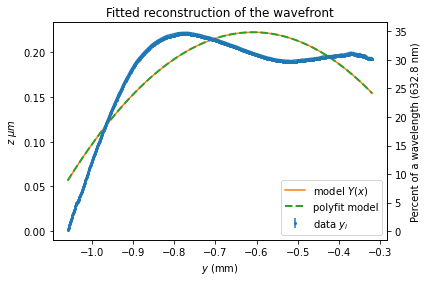

<Figure size 432x288 with 0 Axes>

In [16]:
x = y
y = wavefront
dy = 1e-12*np.ones(len(y))
N = N 
seed(0)           # Initialize random number generator
y += normal(0,dy) # add simulated measurement errors (Gaussian distributed random vector)

#* Fit the data to a straight line or a more general polynomial
M = 3
if M == 2 :  
    #* straight line fit
    [a_fit, sig_a, yy, chisqr] = linreg(x, y, dy)
else: 
    #* Polynomial fit
    [a_fit, sig_a, yy, chisqr] = pollsf(x, y, dy, M)

#* Print out the fit parameters, including their error bars.
print('Fit parameters:')
for i in range(M):
    print('a[%d] = %.15f +/- %.5f' % (i,a_fit[i],sig_a[i]))

# Use built-in numpy function:
deg = M - 1
params, cov = polyfit(x,y,deg,w=1/dy,cov=True)
dparams = sqrt( diag( cov ))
print('polyval best-fit parameters: ', params)
# variance in parameters from diagonal of covariance matrix:
print('parameter uncertainties: ', dparams)
print('Chi-square:', chisqr)


#Define our phi(t) parabola for given Radius of Curvature above
#Compare this with our calculated phi values above (in array a_new)
R = v/a_fit[1]

# construct best-fitting model
xmod = linspace(min(x),max(x),100)
ymod = polyval(params,xmod)
#rcParams.update({'font.size': 20})
#* Graph the data, with error bars, and fitting function.
fig, ax1 = plt.subplots()

y2 = np.array(wavefront)/(1e6*Lambda)*100 #percent of a full wavelength (0.630 micrometers)

ax2 = ax1.twinx()

plt.figure()
ax1.errorbar(x,y,dy,fmt='o',ms=2,label='data $y_i$')   # Graph data with error bars
ax1.plot(x,yy,'-',label='model $Y(x)$')            # Plot the fit on same graph as data
ax1.plot(xmod,ymod,'--',lw=2,label='polyfit model') # polyfit result
ax2.plot(x,y2)
ax1.set_title(r'Fitted reconstruction of the wavefront')
#plt.title('Projectile Motion: ') + air_text)
ax1.set_xlabel('$y$ (mm)')  
ax1.set_ylabel(r'$z$ $\mu m$')
ax2.set_ylabel(r'Percent of a wavelength (' + str(1e9*Lambda) + ' nm)')
ax1.legend(loc='best')

Q-Parameter Equations for Expected Values of Radius of Curvature and Width

In [21]:
#ABCD Matrix Elements

f = 35 #mm
d2 = 14 #mm
d1 = 267 #mm
z = 0 #mm
w0 = eval(input('Enter the initial width [mm]'))
#w0 = 1e3*w_ap*(d1/f-1)**(1)*(1+(z_R/(d1-f))**2)**(1/2) #mm
z_R = np.pi* w0**2 * n/Lambda #Rayleigh range
Lambda = Lambda*1e3 #mm
A = 1 - d2/f
B = (1-d2/f)*d1 + d2
C = -1/f
D = 1 - d1/f

radius = ((A*z+B)**2 + (A*z_R)**2)/(C*A*z_R**2 + (C*z+D)*(A*z+B))
beamwidth = sqrt(Lambda/np.pi)*sqrt(((A*z+B)**2+(A*z_R)**2)/(A*z_R*(C*z+D)-C*z_R*(A*z+B)))
#w2 = beamwidth #mm


print('The width of the beam at the aperture plane is ' + str(beamwidth) + ' mm')
print('The radius of curvature at the aperture plane is ' + str(radius) + ' mm')

Enter the initial width [mm].5
The width of the beam at the aperture plane is 2219.2115928102676 mm
The radius of curvature at the aperture plane is -26.280051660187222 mm
